In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# загружаем библиотеку для анализа интенсивности настроения
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# Извлечение признаков

In [12]:
# Даты
data["review_date"] = pd.to_datetime(data["review_date"])
data["days_since_review"] = data["days_since_review"].apply(lambda x: int(x.split()[0]))
data["review_month"] = data["review_date"].dt.month
data.drop("review_date", axis=1, inplace=True)

In [13]:
# Отрицательные отзывы
good = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 'no complaints', 'nil', 'nothing at all', 'na', 'nothing to dislike', 'liked everything',
              'can t think of anything', 'everything was perfect', 'no', 'absolutely nothing', 'nothing to dislike', 'everything was great', 'nothing to complain about', 'non']
data["is_negative_review"] = data["negative_review"].apply(lambda x: not x.strip().lower() in good)
#data["negative_review"] = data["negative_review"].apply(lambda x: "" if x.strip().lower() in good else x)

In [14]:
# Положительные отзывы
bad = ["no positive", "nothing"]
data["is_positive_review"] = data["positive_review"].apply(lambda x: not x.strip().lower() in bad)
#data["positive_review"] = data["positive_review"].apply(lambda x: "" if x.strip().lower() in bad else x)

In [15]:
# Процент слов
data['positive_words_percent'] = data['review_total_positive_word_counts'] / (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])
data['positive_words_percent_m'] = data['positive_words_percent'] * 1000 / data['total_number_of_reviews']

In [16]:
data['delta_review'] = data['review_total_positive_word_counts'] - data['review_total_negative_word_counts']

In [17]:
# Название отеля
data["is_hotel"] = data["hotel_name"].apply(lambda x: x.lower().find("hotel") > -1)
data["is_plaza"] = data["hotel_name"].apply(lambda x: x.lower().find("plaza") > -1)
data["is_palace"] = data["hotel_name"].apply(lambda x: x.lower().find("palace") > -1)
data["is_inn"] = data["hotel_name"].apply(lambda x: x.lower().find("inn") > -1)

In [18]:
# Теги
import re
def find_num_nights(x):
    finded = re.findall(r"tayed (\d) night", x)
    if len(finded) == 0:
        return int(0)
    return int(finded[0])

data["num_nights"] = data["tags"].apply(find_num_nights)
data["is_leisure_trip"] = data["tags"].apply(lambda x: x.lower().find("leisure trip") > -1)
data["is_mobile_device"] = data["tags"].apply(lambda x: x.lower().find("mobile device") > -1)
data["is_couple"] = data["tags"].apply(lambda x: x.lower().find("couple") > -1)
data["is_double_room"]  = data["tags"].apply(lambda x: x.lower().find("double room") > -1)

In [19]:
import category_encoders as ce
# Адрес
data["hotel_address"] = data["hotel_address"].apply(lambda x: " ".join(x.split()[-2:]))

encoder = ce.OneHotEncoder(cols=['hotel_address']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_address'])
data = pd.concat([data, type_bin], axis=1)

In [20]:
# Национальность
top_nat = ["United Kingdom", "United States of America", "Australia", "Ireland", "United Arab Emirates"]
data["reviewer_nationality"] = data["reviewer_nationality"].apply(lambda x: x.strip() if x.strip() in top_nat else "Other")

bin_encoder = ce.OneHotEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [21]:
# работаем с пакетом символьной и статистической обработки естественного языка для анализа отзывов
sent_analyzer = SentimentIntensityAnalyzer()

# проводим анализ отзывов
data['negative_sent_review'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['positive_sent_review'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# записываем результаты в основной датафрейм в виде отдельных признаков
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['negative_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['positive_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

data.drop("negative_sent_review", axis=1, inplace=True)
data.drop("positive_sent_review", axis=1, inplace=True)

In [22]:
# Получение параметра полярности отзыва
def get_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment_assessments.polarity

data['positive_polarity'] = data['positive_review'].apply(get_polarity)
data['negative_polarity'] = data['negative_review'].apply(get_polarity)

In [23]:
# Получение коэффициента позитивной оценки
tb = Blobber(analyzer=NaiveBayesAnalyzer())

def get_blobber_sentiment(text):
    blobber_sentiment = tb(text).sentiment
    return blobber_sentiment[1]

data['positive_review_pos'] = data['positive_review'].apply(get_blobber_sentiment)
data['negative_review_pos'] = data['negative_review'].apply(get_blobber_sentiment)

# Заполнение пропусков

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 56 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [25]:
# Координаты
coord = data.groupby("hotel_address", as_index=False).agg({"lat": "mean", "lng": "mean"})
for c in coord.values:
    m = data["hotel_address"] == c[0]
    data.loc[m, "lat"] = data.loc[m, "lat"].fillna(c[1])
    data.loc[m, "lng"] = data.loc[m, "lng"].fillna(c[2])

In [26]:
# Процент слов
data["positive_words_percent"] = data["positive_words_percent"].fillna(data["positive_words_percent"].median())
data["positive_words_percent_m"] = data["positive_words_percent_m"].fillna(data["positive_words_percent_m"].median())

# Преобразование признаков

In [27]:
from sklearn import preprocessing
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

columns = [
    "lat", 
    "lng", 
    "days_since_review", 
    "additional_number_of_scoring",
    "review_total_negative_word_counts",
    "total_number_of_reviews",
    "review_total_positive_word_counts",
    "total_number_of_reviews_reviewer_has_given"]
data[columns] = r_scaler.fit_transform(data[columns]) 

# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
columns = [
    "lat", 
    "lng", 
    "days_since_review"]
data[columns] = mm_scaler.fit_transform(data[columns]) 

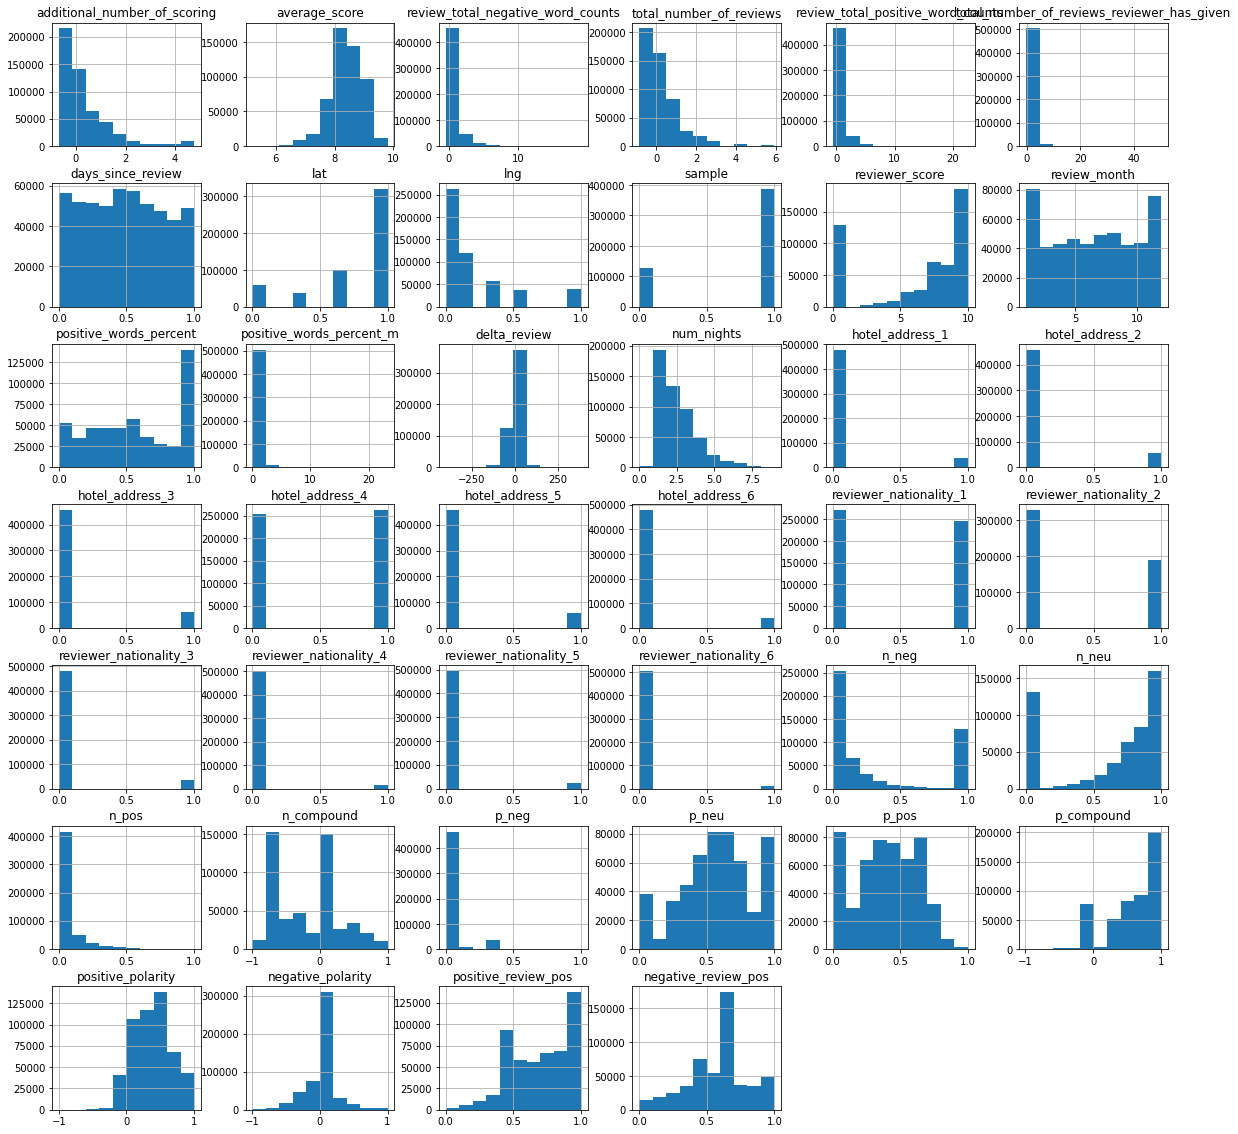

In [28]:
data.hist(figsize=(20, 20));

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 56 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  float64
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  float64
 7   total_number_of_reviews                     515738 non-null  float64
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  float64
 

In [30]:
data.nunique(dropna=False)

hotel_address                                      6
additional_number_of_scoring                     480
average_score                                     34
hotel_name                                      1492
reviewer_nationality                               6
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1475
lng                                             1475
sample                                             2
reviewer_score                                    38
review_month                                      12
is_negative_review                            

# Анализ значимости признаков

In [31]:
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.query('sample == 1').drop(['reviewer_score'], axis = 1)  
y = data.query('sample == 1')['reviewer_score'] 

In [32]:
X.columns

Index(['hotel_address', 'additional_number_of_scoring', 'average_score',
       'hotel_name', 'reviewer_nationality', 'negative_review',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'positive_review', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'review_month',
       'is_negative_review', 'is_positive_review', 'positive_words_percent',
       'positive_words_percent_m', 'delta_review', 'is_hotel', 'is_plaza',
       'is_palace', 'is_inn', 'num_nights', 'is_leisure_trip',
       'is_mobile_device', 'is_couple', 'is_double_room', 'hotel_address_1',
       'hotel_address_2', 'hotel_address_3', 'hotel_address_4',
       'hotel_address_5', 'hotel_address_6', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nationality_3',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_6', 'n_neg', 'n_neu', 'n_p

In [33]:
# непрерывные признаки
num_cols = [
    "total_number_of_reviews", 
    "review_total_negative_word_counts",
    "review_total_positive_word_counts",
    "total_number_of_reviews_reviewer_has_given",
    "additional_number_of_scoring",
    "days_since_review"
]
# категориальные признаки
cat_cols = [
    "average_score",
    "lat",
    "lng",
    "review_month",
    "is_negative_review",
    "is_positive_review",
    "positive_words_percent",
    "positive_words_percent_m",
    'is_hotel', 'is_plaza',
    'is_palace', 'is_inn', 'num_nights', 'is_leisure_trip',
    'is_mobile_device', 'is_couple', 'is_double_room', 'hotel_address_1',
    'hotel_address_2', 'hotel_address_3', 'hotel_address_4',
    'hotel_address_5', 'hotel_address_6', 'reviewer_nationality_1',
    'reviewer_nationality_2', 'reviewer_nationality_3',
    'reviewer_nationality_4', 'reviewer_nationality_5',
    'reviewer_nationality_6'
]

<AxesSubplot:>

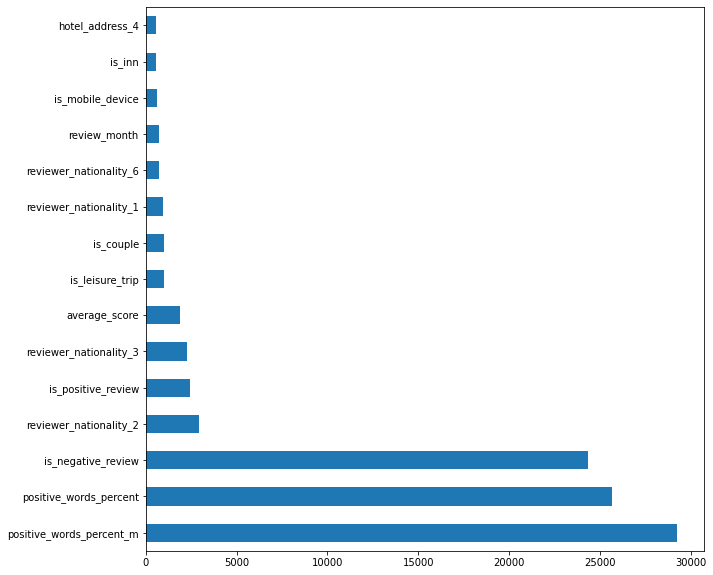

In [34]:
y_int=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

plt.rcParams['figure.figsize'] = (10,10)
imp_cat = pd.Series(chi2(X[cat_cols], y_int)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.nlargest(15).plot(kind = 'barh')

<AxesSubplot:>

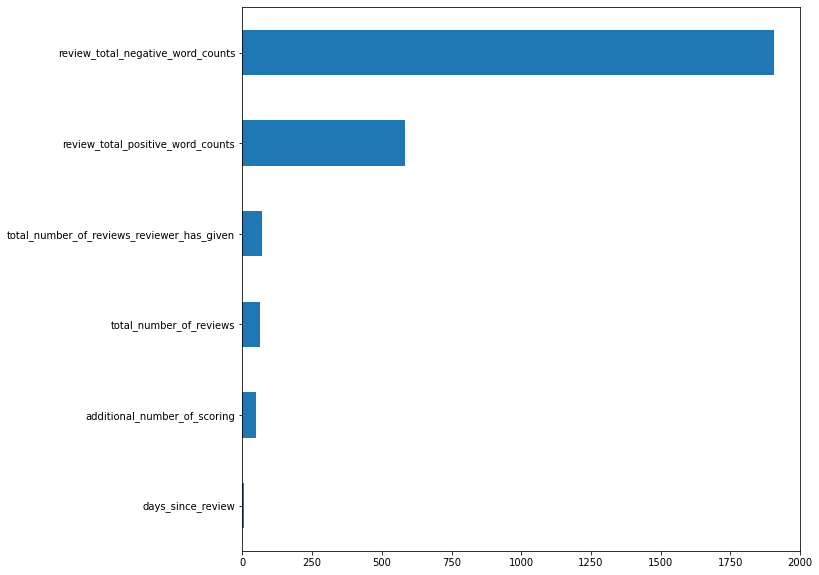

In [35]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Анализ мультиколлинеарности

<AxesSubplot:>

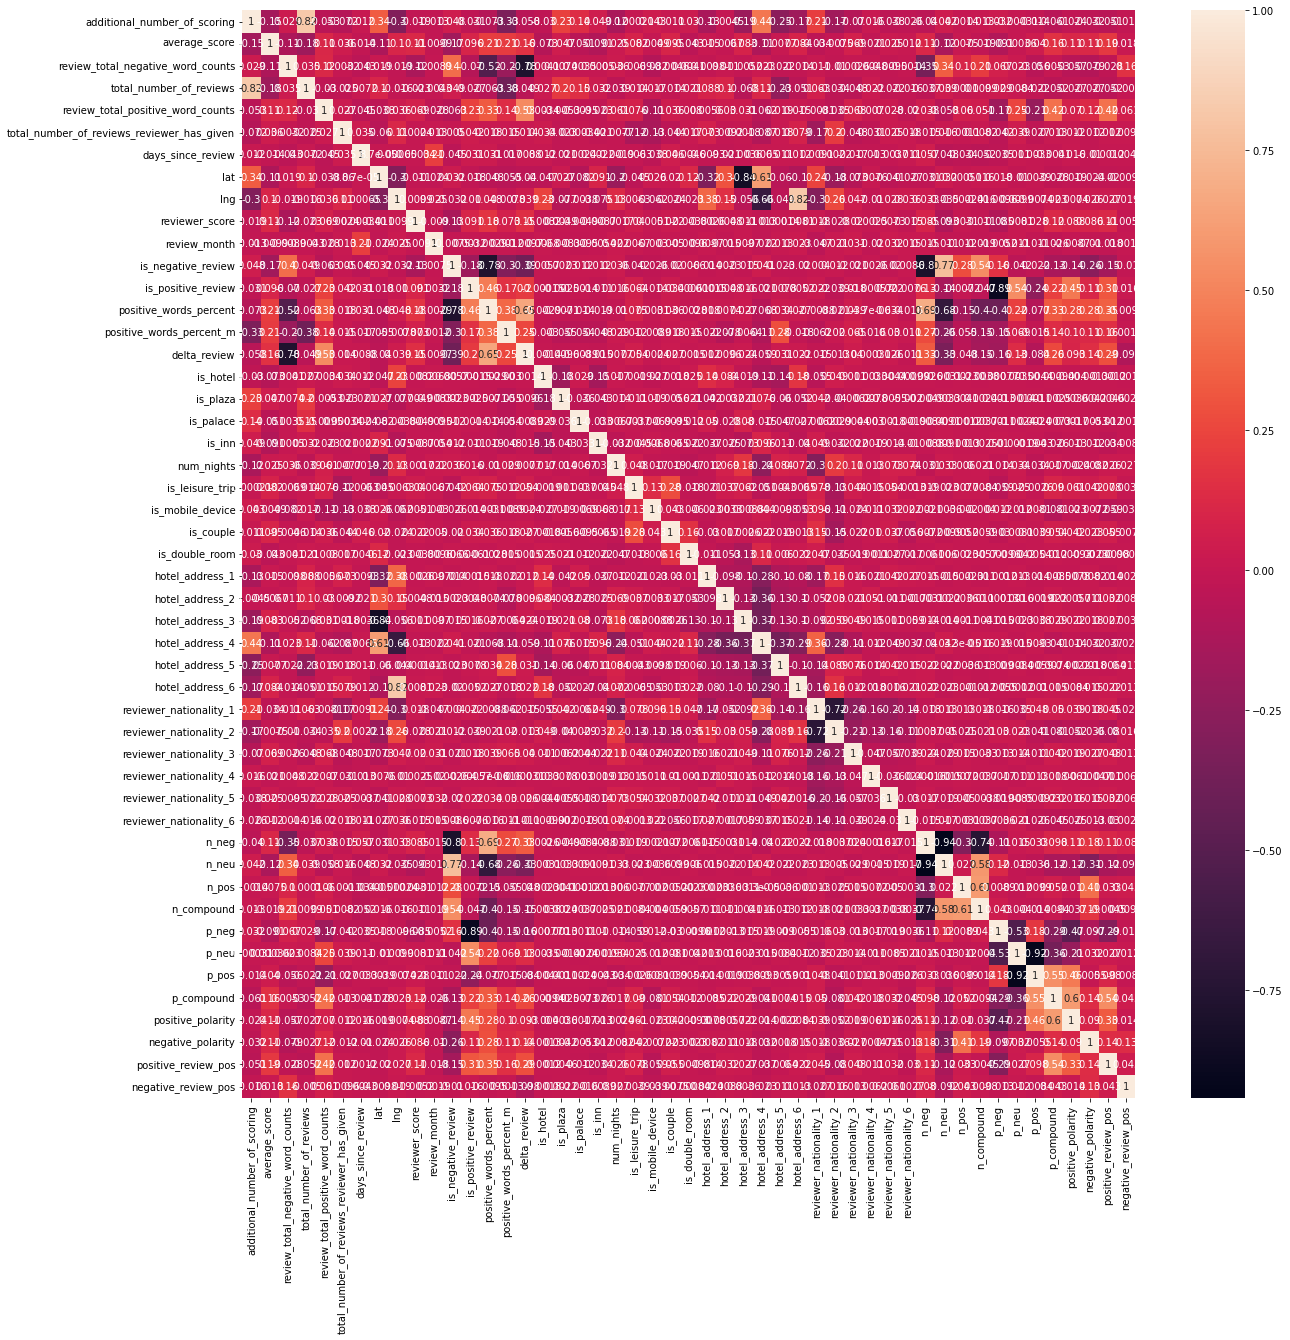

In [36]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [37]:
# Удаляем признаки с высокой корреляцией
corr_matrix = data.drop(['sample'], axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
display(to_drop)

data.drop(to_drop, axis=1, inplace=True)

[]

In [38]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [39]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [40]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [41]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 49), (386803, 49), (386803, 48), (309442, 48), (77361, 48))

In [42]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [43]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [44]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [45]:
# пишем свою функцию Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8521266012590321
MAPE: 12.10457392489726


<AxesSubplot:>

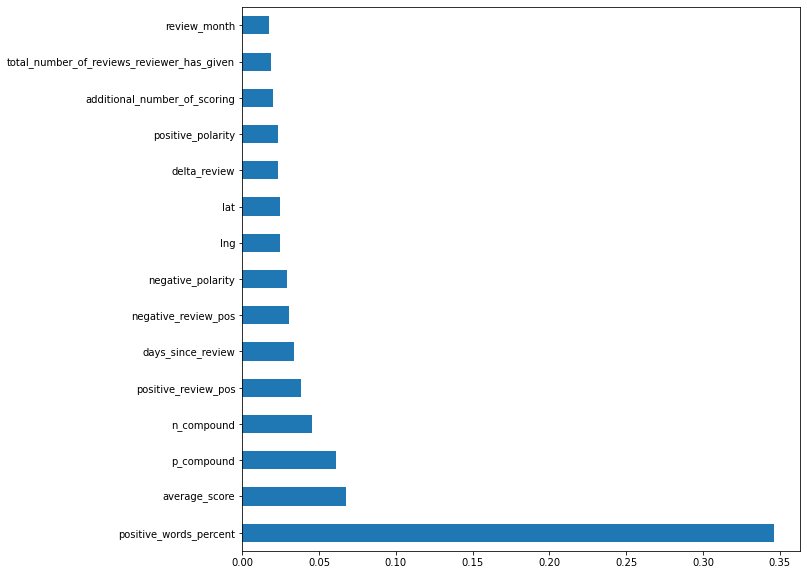

In [47]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [48]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound,positive_polarity,negative_polarity,positive_review_pos,negative_review_pos
106423,0.796334,9.4,-0.428571,0.026917,-0.117647,-0.142857,0.793151,0.919102,0.016918,0.0,...,0.000,-0.7096,0.000,0.307,0.693,0.9062,0.600000,0.150000,0.947511,0.612500
121253,-0.191446,8.6,0.523810,0.771615,0.294118,-0.285714,0.712329,0.619436,0.992446,0.0,...,0.000,0.0000,0.000,0.591,0.409,0.8225,0.750000,0.266667,0.987081,0.547777
30087,0.002037,9.0,0.666667,0.301387,-0.176471,7.428571,0.400000,0.621526,0.996228,0.0,...,0.131,0.1779,0.000,0.377,0.623,0.7650,0.850000,0.286667,0.692639,0.123803
32791,0.156823,8.6,0.857143,-0.229201,-0.352941,-0.285714,0.984932,0.922350,0.013315,0.0,...,0.000,-0.8537,0.000,1.000,0.000,0.0000,0.000000,-0.015952,0.553915,0.720881
71785,0.949084,8.5,-0.428571,0.462887,0.705882,-0.285714,0.431507,0.918085,0.014456,0.0,...,0.000,-0.7096,0.000,0.554,0.446,0.9169,0.344444,0.150000,0.987155,0.612500
69519,-0.179226,8.4,0.047619,0.184339,0.529412,0.428571,0.139726,0.996270,0.318969,0.0,...,0.000,-0.3612,0.000,0.620,0.380,0.8479,0.451389,0.000000,0.993033,0.479413
27080,-0.272912,8.3,-0.095238,-0.246330,-0.470588,-0.142857,0.865753,0.997673,0.313942,0.0,...,0.000,0.0000,0.000,1.000,0.000,0.0000,0.000000,0.000000,0.539852,0.672464
117292,-0.181263,9.1,-0.285714,-0.394780,-0.235294,2.000000,0.720548,0.919391,0.013252,0.0,...,0.000,0.0000,0.000,0.385,0.615,0.7506,0.455556,-0.250000,0.962939,0.626774
66561,0.093686,8.5,-0.095238,-0.220636,0.647059,-0.142857,0.601370,0.920319,0.014663,0.0,...,0.000,-0.2960,0.106,0.667,0.227,0.4767,0.250000,0.000000,0.740849,0.075221
119809,-0.529532,8.7,-0.142857,-0.534258,-0.411765,0.142857,0.415068,0.681570,0.160044,0.0,...,0.000,-0.4767,0.000,0.364,0.636,0.5413,0.487500,-0.400000,0.765153,0.341754


In [49]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [50]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.2s finished


In [51]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.601,488440
1,6.938,274649
2,8.221,374688
3,9.695,404352
4,9.590,451596
5,8.908,302161
6,7.737,317079
7,7.805,13963
8,8.478,159785
9,7.157,195089
